# _Kapitel 8_

# Signalauswertung im Spektralbereich

## Peakfinder zur Ermittlung lokaler Maxima in Spektren
Viele Schwingungsformen im technischen Bereich (z.B. Wellen-schwingungen) haben charakteristische Ausprägungen im Spektral-bereich. Ziel der Auswertung ist es, die Teilamplituden der Grund-schwingung und der auftretenden Harmonischen im Amplitudenspektrum automatisiert zu separieren. Dazu dienen sog. Peakfinder-Algorithmen, die in einschlägiger Signalverarbeitungssoftware (z.B. MATLab) meist fertig vorhanden sind.


Peak positions:  [3, 12, 25, 42, 49, 60]


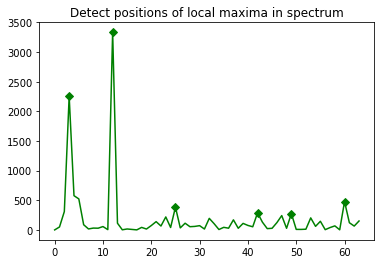

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math
class PeakFinder():
    def _square(self,x):
        for i in range(len(x)): x[i]*=x[i]
        return x
    def _and(self,x,y,z):
        r=np.zeros(len(x))
        for i in range(len(x)):
            r[i]=x[i] & y[i] & z[i]
        return r
    def detect_peaks(self,signal,threshold=10):
        """ Performs peak detection on three steps: root mean square, peak to
        average ratios and first order logic.
        threshold used to discard peaks too small """
        # compute root mean square
        root_mean_square = math.sqrt(np.sum(self._square(signal) / len(signal)))
        # compute peak to average ratios
        ratios = np.array([pow(x / root_mean_square, 2) for x in signal])
        # apply first order logic
        r=np.roll(ratios,1)
        l=np.roll(ratios,-2)
        peaks=self._and(ratios>r,ratios>l,ratios>threshold)
        # return peak indices
        peak_indexes = []
        for i in range(0, len(peaks)):
            if peaks[i]: peak_indexes.append(i)
        return peak_indexes
    pass

n = 128
m = 20
t = np.linspace(0., 1, num=n)
x = np.zeros(n)
for j in range(m):
    phase = 6.28 * random.randrange(m)
    for i in range(n):
        x[i]=np.sin(phase + 75*t[i])+np.sin(21*t[i])-100+3.0*random.random()
x=np.fft.rfft(x)
x=abs(x)
x[0]=0
x=x[:n//2]
pf=PeakFinder()
plt.title("Detect positions of local maxima in spectrum")
peaks=pf.detect_peaks(x,threshold=300)
plt.plot(x,'-gD',markevery=peaks)
print("Peak positions: ",peaks)


## Spektralanalyse mit Filterbänken

Bei der DFT sind die diskreten Analyse-Frequenzpunkte linear über den Bereich 0...f<sub>a</sub>/2 verteilt. Das menschliche Tonhöhenempfinden gehorcht jedoch z.B. einer logarithmischen Frequenzaufteilung (f<sub>k</sub>+1/f<sub>k</sub>=const.). Eine Oktave in der Musik entspricht jeweils einer Frequenzverdopplung bzw. Frequenzhalbierung. Deshalb ist es für viele Anwendungen sinnvoll, eine nichtlineare Frequenzaufteilung des Spektrums durchzuführen. Die kann mittels sog. Filterbänken realisiert werden. Dabei wird pro Analysefrequenzband ein Bandpassfilter mit der entsprechenden Mittenfrequenz und Bandbreite realisiert.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1JxbfWGFzqkXjrKnurMgCXYvZbOKEBlhL' width="450" height="350" />
<figcaption>Filterbank zur Spektralanalyse</figcaption></center>
</figure>

Die Verfahren zur Berechnung von gehörrichtigen Bandfiltern für Oktaven bzw. Bruchteile von Oktaven sind in der Europäischen Norm 
EN 61260 festgelegt. Als Referenzfrequenz _f<sub>r</sub>_ wird üblicherweise 1kHz verwendet. Die exakten Bandmittenfrequenzen _fm_ berechnen sich für gerade Bandbreitenkennzahl _b_ entsprechend 

\begin{equation*}
f_m = s^{x/b} f_r
\end{equation*}

wobei _b_=1 für Oktavband- und _b_=3 für Terzbandanalysen steht.


## Kurzzeit-Spektralanalyse

Frequenzanalysen arbeiten auf Signalausschnitten, die meist Zweierpotenzen entsprechen. Die Frequenzauflösung ist der Blocklänge _N_ direkt, die Zeitauflösung indirekt proportional. Die Wahl einer möglichst großen Transformationslänge verursacht neben einem erhöhten Rechenaufwand auch eine schlechtere zeitliche Auflösung veränderlicher Signale. 

Gerade in der Spracherkennung ist jedoch auch der zeitliche Verlauf des Spektrums von besonderer Wichtigkeit, weshalb Verfahren entwickelt wurden, die einen guten Kompromiss zwischen Zeit- und Frequenzauflösung ermöglichen, die Kurzzeitspektralanalysen (STFA = short time frequency analysis) oder kombinierten Zeit-Frequenzanalysen (JTFA = joint time frequency analysis).

Die Grundidee der STFA ist, das Zeitsignal in überlappende kurze Abschnitte aufzuteilen und diese getrennt zu analysieren:

<figure>
<center>
<img src='https://drive.google.com/uc?id=1j-2fZ2geDqso-g8UpCjN92frvEzV7hi5' width="500" height="400" />
<figcaption>Digitale Spektralanalyse mit FFTs auf zeitlich überlappenden Datenbereichen</figcaption></center>
</figure>

Zur Analyse kann entweder eine FFT (für lineare Frequenzaufteilung) oder eine Filterbak (für log. Frequenzaufteilung) benutzt werden.

## Spektrogramm

Das Spektrogramm ermöglicht eine Darstellung der Intensität (Amplitude oder Leistung) eines Signals über den Parametern Frequenz und Zeit.
Diese 3D-Darstellung wird als Intensitäts-Plot dargestellt (Amplitude als Graustuden oder farbcodiert).

https://colab.research.google.com/github/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/audiofilter.ipynb#scrollTo=oNBCDK1-wmDZ

https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/7303ce3181f4dbc9a50bc1ed5bb3218f/audio_preprocessing_tutorial.ipynb#scrollTo=s5fB-UZ9KkNB

In [6]:
# !pip install torch>=1.2.0
# !pip install torchaudio librosa boto3

%matplotlib inline
import torch
import torchaudio
import matplotlib.pyplot as plt

In [11]:
import requests

url = "https://pytorch.org/tutorials//_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"
r = requests.get(url)

with open('steam-train-whistle-daniel_simon-converted-from-mp3.wav', 'wb') as f:
    f.write(r.content)

filename = "steam-train-whistle-daniel_simon-converted-from-mp3.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

#plt.figure()
#plt.plot(waveform.t().numpy())



Shape of waveform: torch.Size([2, 276858])
Sample rate of waveform: 44100


In [9]:
from IPython.display import Audio, display

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()
  
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")



Sample Rate: 44100
Shape: (2, 276858)
Dtype: torch.float32
 - Max:      0.576
 - Min:     -0.573
 - Mean:     0.000
 - Std Dev:  0.135

tensor([[ 2.7161e-03,  6.3477e-03,  9.2468e-03,  ...,  3.0518e-05,
          0.0000e+00,  0.0000e+00],
        [-3.7537e-03, -1.5259e-03,  1.3123e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])



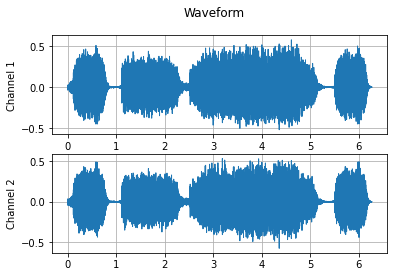

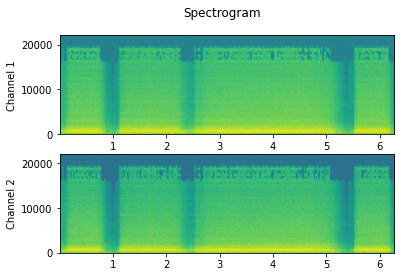

In [12]:
waveform, sample_rate = torchaudio.load(filename)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

## Zeit-/Frequenz-Unschärferelation

Bei der Verarbeitung abgetasteter Signale wird das Abtastintervall gewöhnlich entsprechend der Abtastbedingung aus der Grenzfrequenz (Bandbegrenzung des nicht gefensterten Signals abgeleitet.
Damit liegt ein zeitbegrenztes Signal der Länge _T_ vor, das damit nicht gleichzeitig bandbegrenzt sein kann. Besteht das Zeitfenster aus _N_ Abtastwerten, so besitzt das Spektrum der Kurzzeit-DFT _N_ Spektrallinien. Damit weist das Kurzzeitspektrum in Frequenzrichtung eine Rasterung von

\begin{equation*}
\Delta\omega = 2 \omega_g / N = 2 \pi / (N\Delta t)
\end{equation*}

besitzt.
Gleichermaßen wichtig ist die Rasterung des Kurzzeitspektrums in Zeitrichtung, also die Frage, in welchen zeitlichen Abständen $\Delta\tau$ die Spektraltransformation mindestens durchgeführt werden muss. Dabei ergibt sich (ohne Beweis):

\begin{equation}
\Delta\tau \Delta f = 1/2C 
\end{equation}

mit _C_=1 für das Rechteckfenster und _C_=2 für das Hamming- oder Hanningfenster.

Eine Verfeinerung der Rasterung in Frequenzrichtung führt also zu einer verbröberten Rasterung in Zeitrichtung und umgekehrt. Dieser Auflösungskompromiss wird als Unschärfe bezeichnet und ist typisch für ein Kurzzeitspektrum.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1DWeR3GbrgfF0_PQg_YKkjftFv1So9aHT' width="500" height="250" />
<figcaption>Aufteilung des Rasters zugunsten besserer Zeitauflösung (links) und besserer Frequenzauflösung (rechts)</figcaption></center>
</figure>


## Die Fourier-Time-Transform (FTT)

Die FTT ist eine kombinierte Zeit-/Fraquenzanalyse-Methode (JTFA), die eine variable Skalierung des Auflösungs-Kompromisses abhängig von der jeweiligen Frequenz erlaubt: 

<figure>
<center>
<img src='https://drive.google.com/uc?id=1aP2LbHsWLx8DQ1dDWgPZ86oaVCFfWSMP' width="300" height="260" />
<figcaption>Aufteilung des Rasters zugunsten besserer Zeitauflösung (links) und besserer Frequenzauflösung (rechts)</figcaption></center>
</figure>

Dabei wird - wie bei sog. Wavelet-Transformationen - eine variable Aufteilung des Rasters der Zeit-Frequenz-Ebene verwendet. Das Beispiel im Bild zeigt die Hochlauf- und Auslauf-Phase eines Scheibenwischermotors.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1jO0egXLbMxgVV3-UcO4CkdNoH6IpKoMt' width="500" height="300" />
<figcaption>Kurzzeit-FFT-Analyse (STFA) mit fester Zeit-Frequenz-Rasteraufteilung</figcaption></center>
</figure>

<figure>
<center>
<img src='https://drive.google.com/uc?id=1ma86M-njfeRk8LrOEeHtQ2ekGQy8_3Jx' width="500" height="300" />
<figcaption>Fourier-Time-Transformation (FTT) mit variabler Rasteraufteilung</figcaption></center>
</figure>



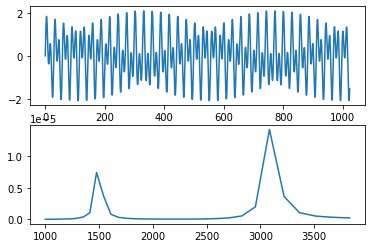

In [9]:
# Fourier Time Transform, Mar, 04.12.2020
M_PI128=0.0245436926
M_2PI  =6.2831853072
class FTT(object):
    m_bark2f=[0.0,100.0,200.0,300.0,400.0,510.0,630.0,770.0,920.0,1080.0,
              1270.0,1480.0,1720.0,2000.0,2320.0,2700.0,3150.0,3700.0,
              4400.0,5300.0,6400.0,7700.0,9500.0,12000.0,15500.0,21800.0,29500.0]
    def __init__(self):
        self.SetParams(44100.0,0,10.0,20000.0,256,0.25,0,1)
        pass
    def SetParams(self,fs,mode,fmin,fmax,fsteps,B,mean,wnd):
        self.m_fsample=fs
        self.m_mode=mode
        self.m_fmin=fmin
        self.m_fmax=fmax
        self.m_fsteps=fsteps
        self.m_B=B
        self.m_mean=mean
        self.m_wnd=wnd
        self.m_m=0
        self.m_a=[0]*self.m_fsteps
        self.m_att=[0]*self.m_fsteps
        self.m_tg=[0]*self.m_fsteps
        self.m_etg=[0]*self.m_fsteps
        self.m_fc=[0]*self.m_fsteps
        self.m_re=[0.0]*self.m_fsteps
        self.m_im=[0.0]*self.m_fsteps
        self.m_re2=[0.0]*self.m_fsteps
        self.m_im2=[0.0]*self.m_fsteps
        self.m_sg=[0]*self.m_fsteps
        self.m_mag=[0]*self.m_fsteps
        self.m_si=[0]*256
        self.m_co=[0]*256
        for i in range(256):
            self.m_co[i]=math.cos(M_2PI/256.0*float(i))
            self.m_si[i]=math.sin(M_2PI/256.0*float(i))
        if self.m_mode==0: # linear
            for i in range(self.m_fsteps):
                self.m_fc[i]=self.m_fmin+i/self.m_fsteps*(self.m_fmax-self.m_fmin)
        elif self.m_mode==1: # logarithmic
            p1=math.log(self.m_fmin/1000.0)/math.log(2.0)
            p2=math.log(self.m_fmax/1000.0)/math.log(2.0)
            for i in range(self.m_fsteps):
                self.m_fc[i]=1000.0*math.pow(2.0,p1+i/self.m_fsteps*(p2-p1))
        else: # bark
            z1=self.Freq2Bark(self.m_fmin)
            z2=self.Freq2Bark(self.m_fmax)
            for i in range(self.m_fsteps):
                self.m_fc[i]=self.Bark2Freq(z1+(z2-z1)*i/self.m_fsteps)
        for i in range(self.m_fsteps):
            t0=0.0
            fr=self.m_fc[i]/1000.0 # / M_2PI
            fg=25.0+75.0*math.pow(1.0+1.4*(fr*fr),0.69)
            self.m_a[i]=fg*math.pi*self.m_B
            self.m_att[i]=math.exp(-self.m_a[i]/self.m_fsample)
            if self.m_fc[i]<3000.0: 
                t0=0.64/fg 
                self.m_tg[i]=1.0/self.m_fsample/t0
            else: 
                self.m_tg[i]=0.000125
            self.m_etg[i]=math.exp(-self.m_tg[i])
            #print(i,self.m_fc[i],self.m_a[i],self.m_att[i],self.m_tg[i],self.m_etg[i])
        pass   
    def SetData(self,data):
        w=0; c=1; mfs2=self.m_fsample*self.m_fsample
        cons=M_2PI/self.m_fsample; cons2=0.0
        l=len(data)
        for i in range(l):
            self.m_m+=1
            cons2=cons*self.m_m
            # Fenster 1. Ordnung
            for j in range(len(self.m_fc)):
                fac=2.0*self.m_a[j]/self.m_fsample
                w=cons2*self.m_fc[j]
                q=int(w/M_PI128) & 0xff
                s=self.m_si[q]
                c=self.m_co[q]
                #s=math.sin(w)
                #c=math.cos(w)
                self.m_re[j]=(self.m_re[j]*self.m_att[j]+data[i]*c*fac)
                self.m_im[j]=(self.m_im[j]*self.m_att[j]-data[i]*s*fac)
            # Fenster 2. Ordnung
            if self.m_wnd:
                for j in range(len(self.m_fc)):
                    fac=self.m_a[j]/mfs2
                    self.m_re2[j]=self.m_att[j]*self.m_re2[j]+self.m_re[j]*fac
                    self.m_im2[j]=self.m_att[j]*self.m_im2[j]+self.m_im[j]*fac
            if self.m_mean>0: # Glättung
                if self.m_wnd:
                    for j in range(len(self.m_fc)):
                        self.m_sg[j]=self.m_etg[j]*self.m_sg[j]+self.m_tg[j]*(self.m_re2[j]*self.m_re2[j]+self.m_im2[j]*self.m_im2[j])
                else:
                    for j in range(len(self.m_fc)):
                        self.m_sg[j]=self.m_etg[j]*self.m_sg[j]+self.m_tg[j]*(self.m_re[j]*self.m_re[j]+self.m_im[j]*self.m_im[j])
            else:
                if self.m_wnd:
                    for j in range(len(self.m_fc)):
                        self.m_sg[j]=(self.m_re2[j]*self.m_re2[j]+self.m_im2[j]*self.m_im2[j])
                else:
                    for j in range(len(self.m_fc)):
                        self.m_sg[j]=(self.m_re[j]*self.m_re[j]+self.m_im[j]*self.m_im[j])
        pass
    def GetSpectrum(self):
        s=[0]*len(self.m_re)
        fac=1.0/self.m_fsample
        if self.m_wnd: fac=self.m_fsample
        for i in range(len(self.m_fc)):
            if self.m_mean>1:
                self.m_mag[i]=(1.0-1.0/self.m_mean)*self.m_mag[i]+(1.0/self.m_mean)*self.m_sg[i]
            else:
                self.m_mag[i]=self.m_sg[i]
            s[i]=self.m_mag[i]*fac/2.0
        return s
    def GetCenterFrequencies(self):
        f=[0]*len(self.m_fc)
        for i in range(len(self.m_fc)):
            if self.m_mode==2:
                f[i]=self.Freq2Bark(self.m_fc[i])
            else:
                f[i]=self.m_fc[i]
        return f
    def Freq2Bark(self,fc):
        z=0.05; f=0.0; fg=0.0; i=0
        while f<fc:
            fg= 25.0+75.0*math.pow(1+1.4*(f/1000*f/1000),0.69)
            f+=z*fg; i+=1
        return i*z
    def Bark2Freq(self,b):
        z=0.0; f=0.0; ib=int(b)
        f=self.m_bark2f[ib]
        while z<=b:
            f+=(25.0+75.0*math.pow(1+1.4*(f/1000*f/1000),0.69))/20.0
            z=self.Freq2Bark(f)
        return f

import math
import matplotlib.pyplot as plt

fs=44100.0
f1=1500
f2=3100
x=[math.sin(M_2PI*f1*i/fs)+1.1*math.sin(M_2PI*f2*i/fs) for i in range(1024)]

ftt=FTT()
ftt.SetParams(44100.0,1,1000.0,4000.0,32,0.25,0,0)
ftt.SetData(x)
s=ftt.GetSpectrum()
f=ftt.GetCenterFrequencies()

fig,axs=plt.subplots(2)
axs[0].plot(x)
axs[1].plot(f,s)


## Die Goertzel-Transformation

Die Goertzel-Transformation bzw. das Goertzelfilter kommt immer dann vorteilhaft zum Einsatz, wenn nur wenige Fourierkoeffizienten eines Fourierspektrums zur Auswertung benötigt werden.
Wird es auf alle Frequenzen angewendet, so entspricht das Ergebnis einer DFT bzw. FFT, hat dann aber keine Geschwindigkeitsvorteile mehr im Vergleich zur DFT. 


In [52]:
import math

def goertzel(x, ft, fs=1.):
    """
    The Goertzel algorithm is an efficient method for evaluating single terms
    in the Discrete Fourier Transform (DFT) of a signal. It is particularly
    useful for measuring the power of individual tones.

    Arguments
    ----------
        x   array [nt,]; the signal to be decomposed
        ft  scalar; the target frequency at which to evaluate the DFT
        fs  scalar; the sample rate of x (same units as ft, default=1)

    Returns
    ----------
        p   scalar; the DFT coefficient corresponding to ft

    See: <http://en.wikipedia.org/wiki/Goertzel_algorithm>
    """
    s = 0
    s_prev = 0
    s_prev2 = 0
    coeff = 2 * math.cos(2 * math.pi * (ft / fs))
    N = x.shape[0]
    for ii in range(N):
        s = x[ii] + (coeff * s_prev) - s_prev2
        s_prev2 = s_prev
        s_prev = s
    return s_prev2 * s_prev2 + s_prev * s_prev - coeff * s_prev * s_prev2

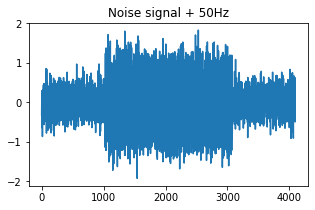

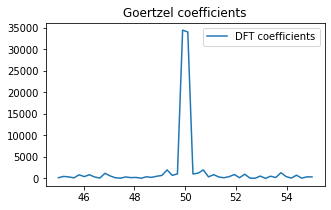

In [66]:
import numpy as np
#from scipy.signal import filter_design, filtfilt

# a signal whose power at 50Hz varies over time
sfreq = 128.
nsamples = 4096
time = np.arange(nsamples) / sfreq
sinusoid = np.sin(2 * np.pi * 50 * time)
pow50hz = np.zeros(nsamples)
pow50hz[nsamples//4 : 3*nsamples//4] = 1
x = pow50hz * sinusoid + 0.3*np.random.randn(nsamples)
plt.figure(figsize=(5,3))
plt.title("Noise signal + 50Hz")
plt.plot(x)

freqs = np.linspace(45, 55, 50)
pows = np.array([goertzel(x, ff, sfreq) for ff in freqs])

#fig, ax = plt.subplots(1, 1)
plt.figure(figsize=(5,3))
plt.title("Goertzel coefficients")
plt.plot(freqs, pows, label='DFT coefficients')
plt.legend(loc=1)

## Die Hilbert-Transformation

https://colab.research.google.com/github/GuitarsAI/ADSP_Tutorials/blob/master/ADSP_11_Complex_S_and_S.ipynb#scrollTo=qmyKkEZHQaI6

Bei den bisherigen Betrachtungen sind wir grundsätzlich von reellen Signalen ausgegangen. Manchmal ist es sinnvoll, diese in der physikalischen Realität begründete Beschränkung fallen zu lassen. Zwei Gründe dafür haben wir bereits kennen gelernt:

- Es kann erhebliche Rechenvorteile mit sich bringen, ein reelles Signal durch ein komplexes zu ersetzen und erst nach ausgeführter Rechnung zu dem reellen Signal zurückzukehren (kompl. Wechselstromrechnung).
- Lässt man nur reelle Signale zu, können nicht alle Symmetrieeigenschaften der Spektralanalyse ausgeschöpft werden. So äußert sich die Verschiebung des Spektrums um 0 in einer Multiplikation des Signals mit dem komplexen Faktor $exp(j\omega t)$; man erhält ein komplexes Signal.

Die Hilbert-Transformation eines kontinuierlichen Zeitbereichssignals ist definiert durch die Integralgleichung:

$$
x_H(t)=\frac{1}{\pi} \int _{- \infty} ^\infty \frac{x(\tau)}{t-\tau} d\tau
$$

Die Hilbert-Transformierte _x<sub>H</sub>(t)_ ergänzt ein reelles Signal _x(t)_ durch Bildung eines Imaginärteils zu einem analytischen Signal _x_. Als analytisches Signal wird ein komplexwertiges Signal bezeichnet, dessen Spektrum auf der negativen Frequenzachse Null ist. Das bedeutet praktisch, dass zu jedem sinusförmigen Signal eine (cosinusförmige) Quadraturkomponente gleicher Amplitude berechnet wird. Mit Hilfe dieser Quadraturkomponente ist eine einfache Demodulation eines Signals möglich. Der formelmäßige Zusammenhang lässt sich aus den Chauchyschen Integralformeln herleiten. Eine effiziente Berechnung kann über die Darstellung im Frequenzbereich erfolgen. Dazu wird obige Gleichung als Faltung

$$
x_H(t) = x(t) * \frac{1}{\pi t}
$$

aufgefasst. Die Fouriertransformierte von $1/(\pi t)$ ergibt sich zu

$$
F(\frac{1}{\pi t}) = -j sgn (f)
$$

mit der Vorzeichenfunktion sgn(f>=0) = 1, bzw. sgn(f<0) = -1.

## Berechnung einer Hüllkurve mit der Hilbert-Tranformation

Zur Durchführung der Hilbert-Transformation wird zunächst die komplexe DFT eines reellen Eingangssignals gebildet und dieses mit der Fouriertransformierten von $1/(\pi t)$ multipliziert, z.B. durch folgende Funktion in C:

```c 
void mult(double *REo, double *IEo, // Ausgabe
          double *REi, double *IMi, // Eingabe
          int N)                    // Abtastwerte
{
int i ;
for(i=0; i<N/2; i++)
     {
     REo[I]= IMi[I];
     IMo[i]=-REi[i];
     }
for(i=N/2; i<N; i++)
     {
     REo[I]=-IMi[I];
     IMo[i]= REi[i];
     }
}
```
Nach der Rücktransformation in den Zeitbereich erfolgt die Berechnung der Hüllkurve erfolgt mittels der Beziehung:

$$
h(t) = \sqrt {(x^2 (t)+x_H^2(t))}
$$

Im folgendem Beipiel wird ein amplitudenmoduliertes Signal erzeugt, dessen Einhüllende (Hüllkurve) und Momentanfrequenz bestimmt werden soll:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp

# Zeitsignal erzeugen
duration = 1.0
fs = 400.0
samples = int(fs*duration)
t = np.arange(samples) / fs


Dazu erzeugen wir ein Chirp-Signal mit ansteigender Frequenz von 20Hz bis 100Hz und einer Amplitudenmodulation:

In [22]:
# Chirp erzeugen (FM)
signal = chirp(t, 20.0, t[-1], 100.0)
# Signal modulieren (AM)
signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )

Die einhüllende Amplitude ergibt sich mit Hilfe des analytischen Signals, die Momentanfrequenz kann durch Ableitung der Momentanphase nach der Zeit erfolgen. Die Momentanphase korrespondiert zum Phasenwinkel des analytischen Signals. 

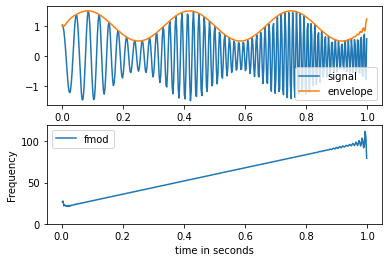

In [30]:
# Hilbert-Transformation ausführen und Hüllkurve, Momentanphase und Momentanfrequenz des Signals berechnen
analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)

fig = plt.figure()
ax0 = fig.add_subplot(211)
ax0.plot(t, signal, label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()
ax1 = fig.add_subplot(212)
ax1.plot(t[1:], instantaneous_frequency, label='fmod')
ax1.set_xlabel("time in seconds")
ax1.set_ylabel('Frequency')
ax1.set_ylim(0.0, 120.0)
ax1.legend()

Damit wurde sowohl die Momentanfrequenz _fmod_ als auch das amplitudenmodulierende Signal (envelope) bestimmt. Mit diesen Algorithmen ist eine softwarebasierte Demodulation von Hochfrequenzsignalen in Software Defines Radios (SDR) möglich. Die (De-)Modulationsarten werden als **AM** (Amplitudenmodulation) und **FM** (Frequenzmodulation) bezeichnet und auch in analogen Radios eingesetzt.

# Auto- und Kreuzkorrelationsfunktionen

Mit Hilfe der Autokorrelationsfunktion lässt sich die Periodizität eines Signals bestimmen. Die Kreuzkorrelationsfunktion vergleicht zwei Muster und liefert bei Übereinstimmung der Signale ein Maximum. Die Definitionen für den zeitkontinuierlichen Fall lauten:

$$
\Phi_{xx}(\tau) = \lim_{T->\infty} \frac{1}{2T} \int _{-\infty} ^\infty x(t) x(t-\tau) dt
$$

$$
\Phi_{yy}(\tau) = \lim_{T->\infty} \frac{1}{2T} \int _{-\infty} ^\infty y(t) y(t-\tau) dt
$$

$$
\Phi_{xy}(\tau) = \lim_{T->\infty} \frac{1}{2T} \int _{-\infty} ^\infty x(t) y(t-\tau) dt
$$

Die letzte Gleichung führt zur Kreuzkorrelationsfunktion der Signale _x(t)_ und _y(t)_.

Die Berechnung kann im Zeitbereich oder im Frequenzbereich erfolgen. Im zweiten Fall werden beide Signale fouriertransformiert, im Spektrum komplex quadriert (AKF) bzw. multipliziert (KKF) und anschließend in den Zeitbereich zurück transformiert.

Die Größen im Spektralbereich werden mit S bezeichnet

$$ 
S_{xx} = X(j\omega) X^* (j\omega) 
$$

$$
S_{yy} = Y(j\omega) Y^* (j\omega)
$$

$$
S_{xy} = X(j\omega) Y^* (j\omega)
$$

und werden entsprechend als Autoleistungsdichtespektrum bzw. Kreuzleistungsdichespektrum bezeichnet.

## Anwendungen der AKF

- Bestimmung der Signalperiodendauer (Maximum der AKF)
- Effektivwertmessung eines Signals (Effektivwert der Wert an der Stelle $\tau=0$ der AKF)

## Anwendungen der KKF
- Laufzeit und Geschwindigkeitsmessungen (Maximum der KKF)
- Ortung durch Laufzeitdifferenzmessung
- Mustererkennung
- Bestimmung von Übertragungefunktionen $G(j\omega)=S_{xy}(j\omega)/S_{xx}(j\omega)$

## Mustererkennung mit der Kreuzkorrelation

<figure>
<center>
<img src='https://drive.google.com/uc?id=1A2lh7iqYAonOx6Cx9Gq-Je9AGSji4iCC' width="450" height="200" />
<figcaption>Suchbild: Wo ist das links gezeigte Muster im Signal versteckt?</figcaption></center>
</figure>

Ein Muster wird an einem Signal entlang geschoben, welches aus dem Muster selbst und ansonsten nur aus Nullwerten besteht. Jeweils übereinander liegende Werte werden multipliziert und alle Produkte anschließend addiert. Bei der mit Nr. 3 bezeichneten Verschiebung sind beide Muster deckungsgleich und das Korrelationsergebnis ist maximal:

<figure>
<center>
<img src='https://drive.google.com/uc?id=1ABxi2AUtGDskTEeLuYMiXBbECmhiktcN' width="450" height="600" />
<figcaption>Prinzip des Kreuzkorrelationsfunktion: An der Stelle g3 ist das Ergebnis maximal</figcaption></center>
</figure>

## Geschwindigkeitsmessung mit der Kreuzkorrelation

Eine klassische Anwendung der Korrelation ist die berührungslose Geschwindigkeitsmessung, z.B. bei rollenden Schienenfahrzeugen:

<figure>
<center>
<img src='https://drive.google.com/uc?id=1XHmdmaP1Te1_y2R_74DTKuxZWIw1j6KD' width="650" height="230" />
<figcaption>Prinzip der optischen Geschwindigkeitsmessung</figcaption></center>
</figure>

Die Gleichheit der beiden Signale _x(t)_ und _y(t-Tv)_ ergibt sich im Maximum der KKF. 

$$
y(t)=x(t-T_v)
$$

Damit folgt für die Geschwindigkeit bei gegebenem Abstand _a_:

$$
v = a/T_v
$$


<figure>
<center>
<img src='https://drive.google.com/uc?id=1qGOHL6fRPHML0-D2Iobk0kCJjjjViuvp' width="650" height="500" />
<figcaption>Die Signale x(t) und y(t) zeigen einen Versatz von Tv=4ms</figcaption></center>
</figure>

